In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [2]:
muesli = pd.read_csv("/Users/tristakuo/neuefische/EDA_Silke_Trista/Muesli.csv", sep= ',', header=1)
order_process = pd.read_csv("/Users/tristakuo/neuefische/EDA_Silke_Trista/Order_Process.csv", sep= ',')
campaign = pd.read_csv("/Users/tristakuo/neuefische/EDA_Silke_Trista/Campaign_Data.csv", sep= ',')
ready_to_ship = pd.read_csv("/Users/tristakuo/neuefische/EDA_Silke_Trista/InternData.csv", sep= ',')

In [3]:
# change column names for all dataframes 

muesli.columns = muesli.columns.str.replace(" ", "_")
muesli.columns = muesli.columns.str.replace("/", "_")
muesli.columns = muesli.columns.str.replace("-", "_")
muesli.columns = [x.lower() for x in muesli.columns]

order_process.columns = order_process.columns.str.replace(" ", "_")
order_process.columns = [x.lower() for x in order_process.columns]

campaign.columns = campaign.columns.str.replace(" ", "_")
campaign.columns = [x.lower() for x in campaign.columns]

ready_to_ship.columns = ready_to_ship.columns.str.replace(" ", "_")
ready_to_ship.columns = [x.lower() for x in ready_to_ship.columns]

In [4]:
# change data type: dates 

muesli['order_date'] = pd.to_datetime(muesli['order_date'], format= '%d/%m/%Y')

order_process['order_date'] = pd.to_datetime(order_process['order_date'],format= '%d/%m/%Y')
order_process['on_truck_scan_date'] = pd.to_datetime(order_process['on_truck_scan_date'],format= '%d/%m/%Y')

campaign['arrival_scan_date'] = pd.to_datetime(campaign['arrival_scan_date'], format= '%d/%m/%Y')
ready_to_ship['ready_to_ship_date'] = pd.to_datetime(ready_to_ship['ready_to_ship_date'],format= '%d/%m/%Y')
ready_to_ship['pickup_date'] = pd.to_datetime(ready_to_ship['pickup_date'], format= '%d/%m/%Y')


In [5]:
# check duplicates 

muesli[muesli.duplicated(keep=False)].count()
ready_to_ship[ready_to_ship.duplicated(keep=False)].count()

# findings: one order with different products will have multiple order_ids (product_id are different)
# this will affect the calculations for ready_to_ship

order_id              147
ready_to_ship_date    147
pickup_date           147
dtype: int64

In [6]:
# copy dataframe "ready_to_ship" and drop the duplicates 

ready_to_ship_cp = ready_to_ship.copy()
ready_to_ship_cp.drop_duplicates(inplace= True)

# check duplicates handling 
ready_to_ship_cp[ready_to_ship_cp.duplicated(keep=False)].count()

order_id              0
ready_to_ship_date    0
pickup_date           0
dtype: int64

In [7]:
# JOIN/MERGE

# JOIN campaign with muesli on order_id into campaign_merge

campaign_merge = pd.merge(campaign, muesli, on= "order_id")

# drop the duplicates for order_id
campaign_merge.drop_duplicates(subset= 'order_id', inplace= True)

In [8]:
# JOIN/MERGE
# JOIN ready_to_ship with campaign on order_id into ready_to_ship_merge

ready_to_ship_merge = pd.merge(ready_to_ship_cp, campaign, on= "order_id")


# KPI Variables 

how many days from order received to be loaded on truck?  
+ order_process['days_order_truck']

how many days between ready to ship and truck pickup 
+ order_process['days_ready_truck']

how many days from order to arrival 
+ campaign_merge['days_order_arrival']

how many days between pickup date and arrival 
+ ready_to_ship_merge['days_truck_arrival']

In [9]:
# calculate important metrics for KPIs

# 1. how many days from order received to be loaded on truck?  
order_process['days_order_truck'] = (order_process['on_truck_scan_date'] - order_process['order_date']).dt.days

# 2. how many days between ready to ship and truck pickup 
ready_to_ship_cp['days_ready_truck'] = (ready_to_ship_cp['pickup_date'] - ready_to_ship_cp['ready_to_ship_date']).dt.days

# 3. how many days from order to arrival 
campaign_merge['days_order_arrival'] = (campaign_merge['arrival_scan_date'] - campaign_merge['order_date']).dt.days

# 4. how many days between pickup date and arrival 
ready_to_ship_merge['days_truck_arrival'] = (ready_to_ship_merge['arrival_scan_date'] - ready_to_ship_merge['pickup_date']).dt.days 


6.120528903203933

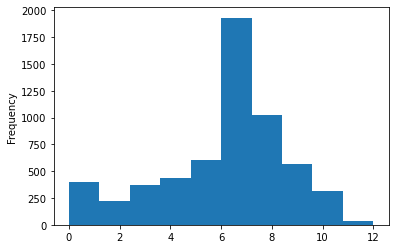

In [10]:
# plotting: 1. how many days from order received to be loaded on truck?  
order_process.days_order_truck.plot(kind= 'hist');
order_process.days_order_truck.mean()

# Findings: it takes avg. 6 days to process orders (from order_received ~ ready_to_ship ~ scan_on_truck) 
# warehouse manager claimed takes 2 days + 1 or 2 days for this process 

1.5735294117647058

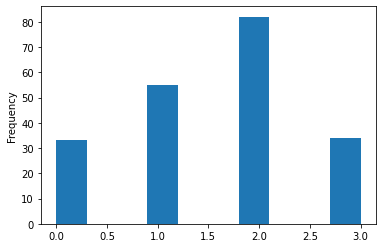

In [11]:
# plotting: 2. how many days between ready to ship and truck pickup 
ready_to_ship_cp['days_ready_truck'].plot(kind= 'hist');
ready_to_ship_cp['days_ready_truck'].mean()

# Findings: it takes avg. 1.57 days from ready_to_ship to scan_on_truck 
# meaning it takes avg 6.12 - 1.65 days from order_date to ready_to_ship

10.834834834834835

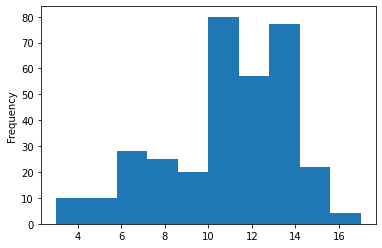

In [12]:
# plotting: 3. how many days from order to arrival 
campaign_merge['days_order_arrival'].plot(kind= 'hist');
campaign_merge['days_order_arrival'].mean()

# Findings: it takes avg. 10.83 days for customers to receive products after they place orders

4.681818181818182

5.0

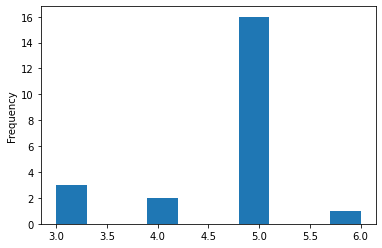

In [13]:
# plotting: 4. how many days between pickup date and arrival 
ready_to_ship_merge['days_truck_arrival'].plot(kind= 'hist')
display(ready_to_ship_merge['days_truck_arrival'].mean(),
        ready_to_ship_merge['days_truck_arrival'].median()
)

# Findings: in most cases it took 5 days from scan_on_truck to customers doors (logistic company delivery)
# according to the logistic company the avg. delivery day is 3 days 

In [14]:
# calculate on-time rate 
# extract year and month from the order_date into order_month and order_year

muesli['order_month'] = muesli['order_date'].dt.month
muesli['order_year'] = muesli['order_date'].dt.year

ready_to_ship['order_month'] = ready_to_ship['ready_to_ship_date'].dt.month
ready_to_ship['order_year'] = ready_to_ship['ready_to_ship_date'].dt.year

campaign_merge['order_month'] = campaign_merge['order_date'].dt.month
campaign_merge['order_year'] = campaign_merge['order_date'].dt.year

order_process['order_month'] = order_process['order_date'].dt.month
order_process['order_year'] = order_process['order_date'].dt.year

ready_to_ship_merge['order_month'] = ready_to_ship_merge['ready_to_ship_date'].dt.month
ready_to_ship_merge['order_year'] = ready_to_ship_merge['ready_to_ship_date'].dt.year


In [15]:
# to on-time dispatch rate

# on_time_dispatch_rate (from order received to on truck)
# Create 2 new columns that say if 
order_process['days_order_truck_T'] = np.where(order_process['days_order_truck'] <= 4, 1, 0)
order_process['days_order_truck_F'] = np.where(order_process['days_order_truck'] > 4, 1, 0)

order_process_month = order_process.groupby(['order_year', 'order_month']).sum()
order_process_month['on_time_dispatch'] = order_process_month['days_order_truck_T'] / (order_process_month['days_order_truck_T'] + order_process_month['days_order_truck_F'])


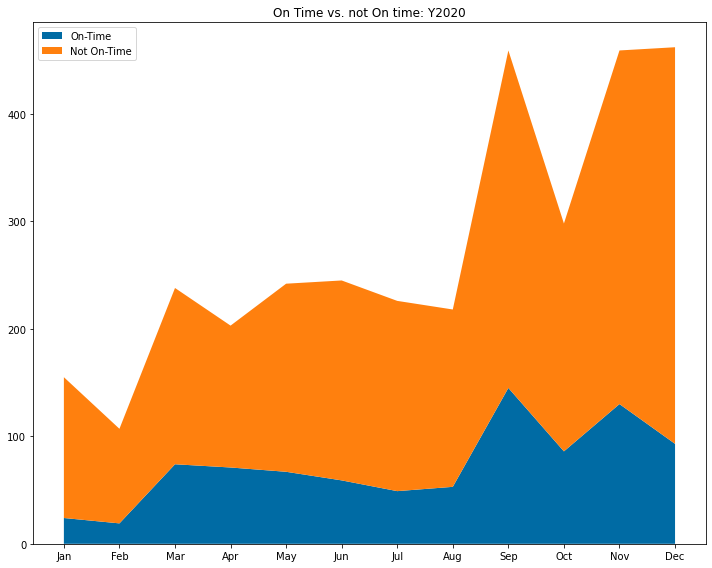

In [28]:
#plotting: on-time vs not on-time in 2020

months = ["Jan", "Feb", "Mar","Apr", "May","Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

order_process_month_20 = order_process_month.query('order_year == 2020')
labels = ['On-Time', 'Not On-Time']

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,8))

plt.stackplot(months, order_process_month_20['days_order_truck_T'], order_process_month_20['days_order_truck_F'],labels=labels)
plt.title("On Time vs. not On time: Y2020")

plt.legend(loc= 'upper left')
plt.tight_layout()

plt.show()

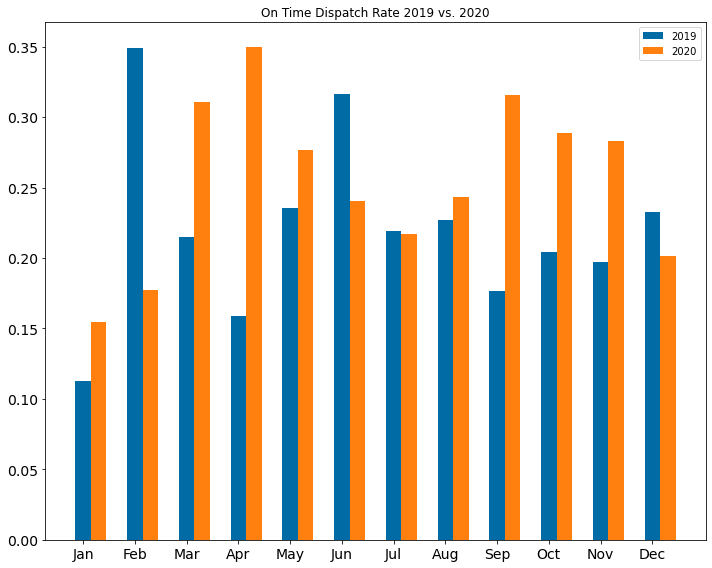

In [17]:
#plotting: On Time Dispatch Rate 2019 vs. 2020

order_process_year = order_process.groupby(['order_year']).sum()
order_process_year['on_time_dispatch'] = order_process_year['days_order_truck_T'] / (order_process_year['days_order_truck_T'] + order_process_year['days_order_truck_F'])

on_time_dispatch_rate_20 = order_process_month.query('order_year == 2020')
on_time_dispatch_rate_19 = order_process_month.query('order_year == 2019')

months = ["Jan", "Feb", "Mar","Apr", "May","Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
x_indexes = np.arange(len(months))
width = 0.3

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,8))

plt.bar(x_indexes, on_time_dispatch_rate_19['on_time_dispatch'], width= width, label = "2019")
plt.bar(x_indexes + width, on_time_dispatch_rate_20['on_time_dispatch'], width= width, label= "2020")

plt.title("On Time Dispatch Rate 2019 vs. 2020")

plt.xticks(ticks= x_indexes, labels= months, fontsize= 14)
plt.yticks(fontsize= 14)

plt.legend()
plt.tight_layout()

plt.show()



In [29]:
# on_time_truck_rate

# split month and year in df ready_to_ship_cp
ready_to_ship_cp['order_month'] = ready_to_ship_cp['ready_to_ship_date'].dt.month
ready_to_ship_cp['order_year'] = ready_to_ship_cp['ready_to_ship_date'].dt.year

#Create 2 new columns that say if 
ready_to_ship_cp['days_ready_truck_T'] = np.where(ready_to_ship_cp['days_ready_truck'] <= 2, 1, 0)

ready_to_ship_cp['days_ready_truck_F'] = np.where(ready_to_ship_cp['days_ready_truck'] > 2, 1, 0)

ready_to_ship_month = ready_to_ship_cp.groupby(['order_year', 'order_month']).sum()
ready_to_ship_month['on_time_truck_rate'] = ready_to_ship_month['days_ready_truck_T'] / (ready_to_ship_month['days_ready_truck_T'] + ready_to_ship_month['days_ready_truck_F'])

ready_to_ship_month

days_ready_truck  days_ready_truck_T  \
order_year order_month                                         
2019       9                          89                  54   
           10                          8                   4   
2020       11                        205                 105   
           12                         19                   7   

                        days_ready_truck_F  on_time_truck_rate  
order_year order_month                                          
2019       9                             5            0.915254  
           10                            1            0.800000  
2020       11                           25            0.807692  
           12                            3            0.700000

In [30]:
# limited data on ready_to_ship_date (290 rows)
# let's compare them by year

ready_to_ship_year = ready_to_ship_cp.groupby(['order_year']).sum()
ready_to_ship_year['on_time_truck_rate'] = ready_to_ship_year['days_ready_truck_T'] / (ready_to_ship_year['days_ready_truck_T'] + ready_to_ship_year['days_ready_truck_F'])

ready_to_ship_year

,days_ready_truck,order_month,days_ready_truck_T,days_ready_truck_F,on_time_truck_rate
order_year,,,,,
2019,97,581,58,6,0.90625
2020,224,1550,112,28,0.80000


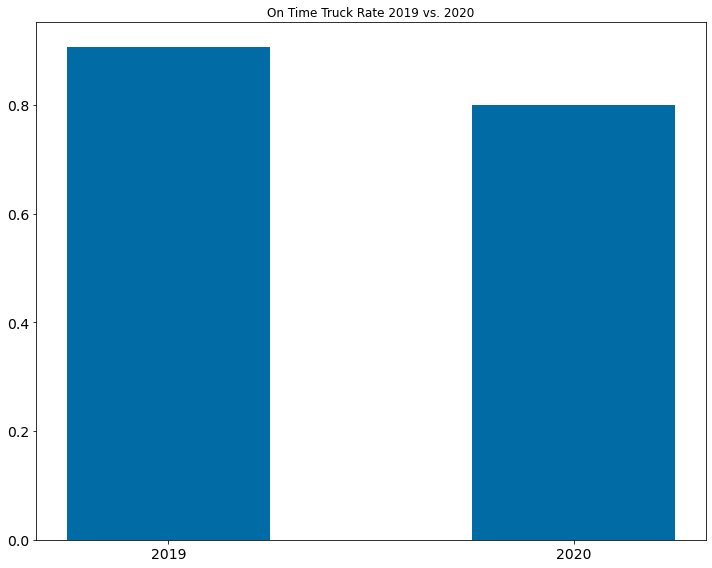

In [20]:
# plotting: On Time Truck Rate 2019 vs. 2020

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,8))


years = [2019, 2020]

plt.bar(years,ready_to_ship_year['on_time_truck_rate'], width= 0.5)

plt.title("On Time Truck Rate 2019 vs. 2020")
plt.xticks(ticks= years, labels= years, fontsize= 14)
plt.yticks(fontsize =14)

plt.tight_layout()

plt.show()

In [31]:
# on_time_logistic_rate 2019

ready_to_ship_merge['days_truck_arrival_T'] = np.where(ready_to_ship_merge['days_truck_arrival'] <= 3, 1, 0)

ready_to_ship_merge['days_truck_arrival_F'] = np.where(ready_to_ship_merge['days_truck_arrival'] > 3, 1, 0)

ready_to_ship_merge_year = ready_to_ship_merge.groupby('order_year').sum()
ready_to_ship_merge_year['on_time_logistic_rate'] = ready_to_ship_merge_year['days_truck_arrival_T'] / (ready_to_ship_merge_year['days_truck_arrival_T'] + ready_to_ship_merge_year['days_truck_arrival_F'])


ready_to_ship_merge_year['on_time_logistic_fail'] = 1- ready_to_ship_merge_year['on_time_logistic_rate']

ready_to_ship_merge_year

,days_truck_arrival,order_month,days_truck_arrival_T,days_truck_arrival_F,on_time_logistic_rate,on_time_logistic_fail
order_year,,,,,,
2019,103,199,3,19,0.136364,0.863636


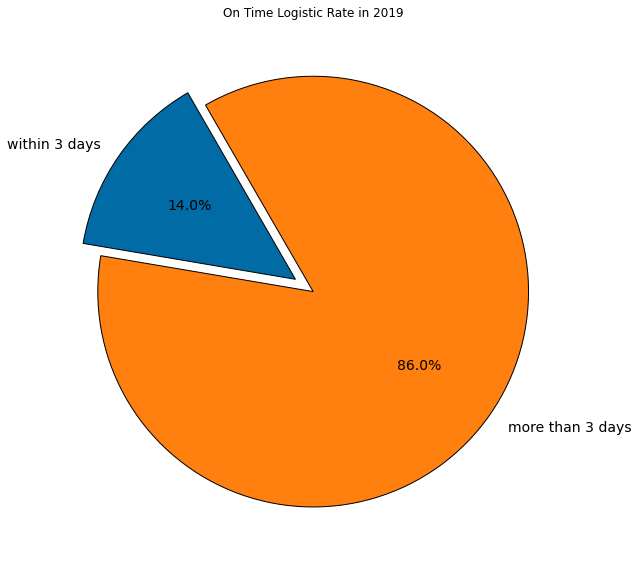

In [24]:
# plotting: On Time Logistic Rate in 2019

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,8))

slices = [14, 86]
labels = ['within 3 days', 'more than 3 days']
explode = [0.1, 0]

plt.pie(slices, labels=labels, explode= explode, startangle= 120, autopct= '%1.1f%%', textprops={'fontsize': 14}, wedgeprops= {'edgecolor': 'black'})
plt.title("On Time Logistic Rate in 2019")

plt.tight_layout()
plt.show()

In [25]:
# on_time_arrival_rate

campaign_merge['days_order_arrival_T'] = np.where(campaign_merge['days_order_arrival'] <= 7, 1, 0)

campaign_merge['days_order_arrival_F'] = np.where(campaign_merge['days_order_arrival'] > 7, 1, 0)

campaign_merge_year = campaign_merge.groupby('order_year').sum()
campaign_merge_year['on_time_arrival'] = campaign_merge_year['days_order_arrival_T'] / (campaign_merge_year['days_order_arrival_T'] + campaign_merge_year['days_order_arrival_F'])


,index,postal_code,sales,quantity,discount,profit,days_order_arrival,order_month,days_order_arrival_T,days_order_arrival_F,on_time_arrival
order_year,,,,,,,,,,,
2019,1383925,15775274.0,78916.503,1087,41.0,19860.9353,3057,2423,37,243,0.132143
2020,294479,3416632.0,15506.141,196,8.9,-1751.6416,551,138,11,42,0.207547


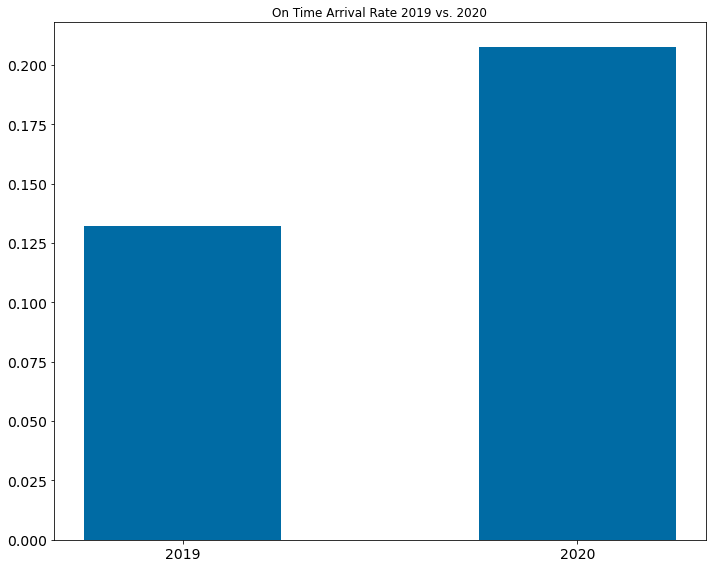

In [26]:
# plotting: On Time Arrival Rate 2019 vs. 2020

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,8))

years = [2019, 2020]

plt.bar(years,campaign_merge_year['on_time_arrival'], width= 0.5)

plt.title("On Time Arrival Rate 2019 vs. 2020")
plt.xticks(ticks= years, labels= years, fontsize= 14)
plt.yticks(fontsize =14)

plt.tight_layout()

plt.show()